In [1]:
import pandas as pd
import numpy as np
import datetime

from sklearn.cross_validation import LeaveOneOut
from sklearn.grid_search import (GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier # Used for imputing rare / missing values

# Regressors considered:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge # only model used for final submission

/Users/priya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/priya/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv', index_col = 0, parse_dates=[1])
test = pd.read_csv('test.csv', index_col = 0, parse_dates=[1])
print ("Train Dimensions:")
print (train.shape)
print ("Test Dimensions:")
print (test.shape)


Train Dimensions:
(137, 42)
Test Dimensions:
(100000, 41)


In [3]:

# Concatenate train and test together to pre-process and featurize both consistently.
df = pd.concat((test, train), ignore_index=True)
df.describe()

/Users/priya/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


P1            P10            P11            P12  \
count  100137.000000  100137.000000  100137.000000  100137.000000   
mean        4.087930       5.459011       3.311653       5.061765   
std         2.813085       1.763709       2.067903       1.765647   
min         1.000000       4.000000       1.000000       2.000000   
25%         2.000000       5.000000       2.000000       4.000000   
50%         3.000000       5.000000       3.000000       5.000000   
75%         4.000000       5.000000       4.000000       5.000000   
max        15.000000      10.000000      10.000000      10.000000   

                 P13            P14            P15            P16  \
count  100137.000000  100137.000000  100137.000000  100137.000000   
mean        5.086621       1.280276       1.305641       1.747336   
std         0.979414       2.497106       2.167272       3.172481   
min         3.000000       0.000000       0.000000       0.000000   
25%         5.000000       0.000000       0.000000       0.000000   
50%         5.000000       0.000000       0.000000       0.000000   
75%         5.000000       2.000000       2.000000       3.000000   
max         7.500000      15.000000      10.000000      15.000000   

                 P17            P18      ...                 P35  \
count  100137.000000  100137.000000      ...       100137.000000   
mean        1.156715       1.708789      ...            1.833099   
std         2.432137       3.030907      ...            3.229052   
min         0.000000       0.000000      ...            0.000000   
25%         0.000000       0.000000      ...            0.000000   
50%         0.000000       0.000000      ...            0.000000   
75%         2.000000       4.000000      ...            4.000000   
max        15.000000      15.000000      ...           15.000000   

                 P36            P37             P4             P5  \
count  100137.000000  100137.000000  100137.000000  100137.000000   
mean        1.969222       0.973696       4.395992       1.989614   
std         3.806280       1.677427       1.035796       1.065518   
min         0.000000       0.000000       2.000000       1.000000   
25%         0.000000       0.000000       4.000000       1.000000   
50%         0.000000       0.000000       4.000000       2.000000   
75%         3.000000       2.000000       5.000000       2.000000   
max        20.000000       8.000000       7.500000       8.000000   

                  P6             P7             P8             P9  \
count  100137.000000  100137.000000  100137.000000  100137.000000   
mean        2.882551       5.300678       4.931304       5.251645   
std         1.532502       2.178739       1.718699       1.702825   
min         1.000000       1.000000       1.000000       4.000000   
25%         2.000000       5.000000       4.000000       4.000000   
50%         2.000000       5.000000       5.000000       5.000000   
75%         4.000000       5.000000       5.000000       5.000000   
max        10.000000      10.000000      10.000000      10.000000   

            revenue  
count  1.370000e+02  
mean   4.453533e+06  
std    2.576072e+06  
min    1.149870e+06  
25%             NaN  
50%             NaN  
75%             NaN  
max    1.969694e+07  

[8 rows x 38 columns]

In [4]:
# Convert date strings to "days open" numerical value
from matplotlib import pylab
%matplotlib inline
df["Open Date"] = df["Open Date"].apply(pd.to_datetime)
last_date = df["Open Date"].max()
df.head()

City  City Group  Open Date  P1  P10  P11  P12  P13  P14  P15  \
0           Niğde       Other 2011-01-22   1    5    5    3  4.0    0    0   
1           Konya       Other 2011-03-18   3    4    2    4  5.0    0    0   
2          Ankara  Big Cities 2013-10-30   3    5    4    5  5.0    0    0   
3         Kocaeli       Other 2013-05-06   2    4    3    4  5.0    0    0   
4  Afyonkarahisar       Other 2013-07-31   2    4    3    5  4.0    0    0   

    ...     P36  P37   P4  P5  P6  P7  P8  P9  Type  revenue  
0   ...       0    0  4.0   1   2   5   4   5    FC      NaN  
1   ...       0    0  4.0   2   2   5   3   4    IL      NaN  
2   ...       0    0  4.0   2   2   5   4   4    FC      NaN  
3   ...       0    0  4.0   2   3   5   4   5    IL      NaN  
4   ...       0    0  4.0   1   2   5   4   5    FC      NaN  

[5 rows x 42 columns]

In [5]:
df["Open Date"] = last_date - df["Open Date"] # This becomes a datetime delta object
df["Open Date"] = df["Open Date"].dt.days + 1 # converts the delta object to an int

In [6]:
df["Log Days Opened"] = df["Open Date"].apply(np.log)
df = df.drop(["Open Date"], axis=1)
pylab.rcParams['figure.figsize'] = (8, 6) # Resizes plots
df[["Log Days Opened", "revenue"]].plot(x="Log Days Opened", y="revenue", kind='scatter', title="Log (Days Opened) vs Revenue")

In [7]:
# Lin noticed that a certain set of columns are either all zero or all non-zero.  
# We added a feature to mark this  - The "zeros" feature will be 17 for these rows
# and 0 or 1 for the rows which are never or rarely zero.
import matplotlib.pyplot as plt
# The features with the notable zero behavior:
zero_cols = ['P14', 'P15', 'P16', 'P17', 'P18', 'P24', 'P25', 'P26', 'P27', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37']

# We make a feature that holds this count of zero columns in the above list
df['zeros'] = (df[zero_cols] == 0).sum(1)

pylab.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1,2)

print ("Distribution of new Zeros features:")
# We find there is only 1 row with a zero count between 0 and 17 in the train set, 
df['zeros'].ix[pd.notnull(df.revenue)].value_counts().plot(title="Train Set", kind='bar', ax=axs[0])

# But in the test set there are many rows with an intermediate count of zeros. 
# This is probably an artifact of how the fake test data was generated (conditional 
# dependence between columns was not preserved).
df['zeros'].ix[pd.isnull(df.revenue)].value_counts().plot(title="Test Set", kind='bar', ax=axs[1], color='red')
plt.show()

Distribution of new Zeros features:


In [8]:
df['City Group'].value_counts()

Other         50787
Big Cities    49350
Name: City Group, dtype: int64

In [9]:
df['Type'].value_counts()
df.loc[df.Type.isin(['MB','DT']),'Type']='FC'

In [10]:
df['City Group'].value_counts()
df=df.join(pd.get_dummies(df['City Group'],prefix='CG'))
df=df.join(pd.get_dummies(df['Type'],prefix='T'))

In [11]:
df = df.drop(["City Group", "Type", "CG_Other"], axis=1)
df.shape

(100137, 44)

In [12]:
df.City.value_counts()

İstanbul          34137
Ankara             8739
İzmir              6474
Antalya            5915
Kocaeli            4365
Mersin             2735
Adana              2517
Balıkesir          2464
Bursa              2446
Muğla              1825
Aydın              1619
Tekirdağ           1580
Konya              1578
Gaziantep          1488
Edirne             1231
Manisa             1227
Çanakkale           965
Denizli             965
Diyarbakır          957
Hatay               951
Zonguldak           926
Eskişehir           903
Trabzon             662
Aksaray             650
Bolu                632
Yalova              630
Kırıkkale           622
Malatya             616
Şanlıurfa           610
Mardin              610
                  ...  
Artvin              344
Bilecik             339
Afyonkarahisar      332
Samsun              329
Nevşehir            328
Kayseri             326
Sivas               326
Kırşehir            319
Erzincan            319
Ordu                317
Erzurum         

In [13]:
df['City']=df.City.replace(df.City.value_counts())
df["Log_City_Count"] = df["City"].apply(np.log) 
df = df.drop(["City"], axis=1)


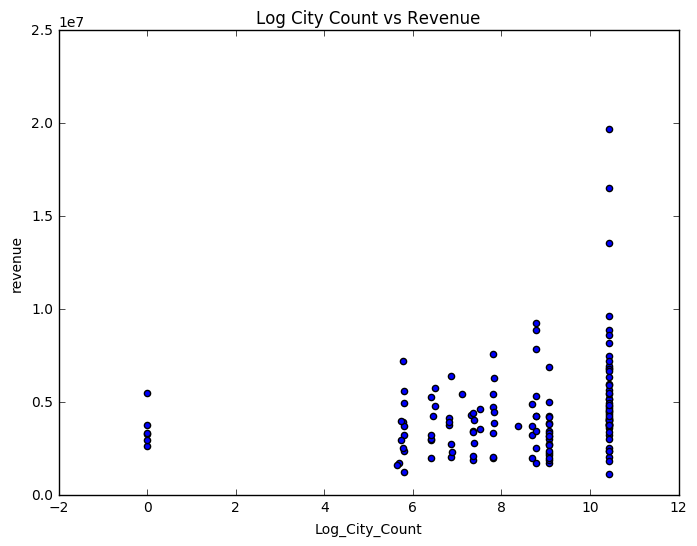

In [14]:
# That last vertical spread of points are restaurants from Istanbul.
pylab.rcParams['figure.figsize'] = (8, 6) # Resizes plots
df[["Log_City_Count", "revenue"]].plot(x="Log_City_Count", y="revenue", kind='scatter', title="Log City Count vs Revenue")

In [15]:


# Now binarize the "P" columns with dummy variables
print ("Pre-binarizing columns:", len(df.columns))
for col in df.columns:
    if col[0] == 'P':
        df = df.join(pd.get_dummies(df[col], prefix=col))
        df = df.drop([col, df.columns[-1]], axis=1)
print ("Post-binarizing columns:", len(df.columns))



Pre-binarizing columns: 44
Post-binarizing columns: 280


In [89]:
# Scale all input features to between 0 and 1, critical to do this for KNN or SVR models.
min_max_scaler = MinMaxScaler()
# Don't scale the output - drop it temporarily
rev = df.revenue
df = df.drop(['revenue'], axis=1)

df = pd.DataFrame(data = min_max_scaler.fit_transform(df), columns = df.columns, index=df.index)
df = df.join(rev)

# Done with preprocessing. Let's take a last look at the data before modeling with it.
df.describe()

/Users/priya/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Log Days Opened          zeros  CG_Big Cities           T_FC  \
count    100137.000000  100137.000000  100137.000000  100137.000000   
mean          0.803995       0.658151       0.492825       0.595484   
std           0.124607       0.360692       0.499951       0.490801   
min           0.000000       0.000000       0.000000       0.000000   
25%           0.735570       0.352941       0.000000       0.000000   
50%           0.822789       0.764706       0.000000       1.000000   
75%           0.886367       1.000000       1.000000       1.000000   
max           1.000000       1.000000       1.000000       1.000000   

                T_IL  Log_City_Count           P1_1           P1_2  \
count  100137.000000   100137.000000  100137.000000  100137.000000   
mean        0.404516        0.824435       0.051989       0.224752   
std         0.490801        0.151901       0.222005       0.417421   
min         0.000000        0.000000       0.000000       0.000000   
25%         0.000000        0.705482       0.000000       0.000000   
50%         0.000000        0.832069       0.000000       0.000000   
75%         1.000000        1.000000       0.000000       0.000000   
max         1.000000        1.000000       1.000000       1.000000   

                P1_3           P1_4      ...                P8_3  \
count  100137.000000  100137.000000      ...       100137.000000   
mean        0.228447       0.282912      ...            0.061745   
std         0.419834       0.450416      ...            0.240694   
min         0.000000       0.000000      ...            0.000000   
25%         0.000000       0.000000      ...            0.000000   
50%         0.000000       0.000000      ...            0.000000   
75%         0.000000       1.000000      ...            0.000000   
max         1.000000       1.000000      ...            1.000000   

                P8_4           P8_5           P8_6           P8_8  \
count  100137.000000  100137.000000  100137.000000  100137.000000   
mean        0.381507       0.393970       0.015888       0.065620   
std         0.485759       0.488631       0.125044       0.247618   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         1.000000       1.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

                P9_4           P9_5           P9_6           P9_8  \
count  100137.000000  100137.000000  100137.000000  100137.000000   
mean        0.351429       0.499396       0.003066       0.065271   
std         0.477419       0.500002       0.055285       0.247004   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         1.000000       1.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

            revenue  
count  1.370000e+02  
mean   4.453533e+06  
std    2.576072e+06  
min    1.149870e+06  
25%             NaN  
50%             NaN  
75%             NaN  
max    1.969694e+07  

[8 rows x 280 columns]

In [90]:
train = df.ix[pd.notnull(df.revenue)]
test = df.ix[pd.isnull(df.revenue)].drop(['revenue'], axis=1)
y = train.revenue.apply(np.sqrt)
X = train.drop(["revenue"], axis=1)

In [91]:
# Now define and train a Ridge Regression model. We tested others from the sklearn package:
# SVR, RandomForest, K-nearest Neighbors, but found Ridge consistantly gave the strongest 
# leaderboard results. When training data is small, simplest is often best.
model_grid = [{'normalize': [True, False], 'alpha': np.logspace(0,10)}]
model = Ridge()

# Use a grid search and leave-one-out CV on the train set to find the best regularization parameter to use.
# (might take a minute or two)
grid = GridSearchCV(model, model_grid, cv=LeaveOneOut(len(y)), scoring='neg_mean_squared_error',verbose=1)
grid.fit(X, y)
print("Best parameters set found on development set:")
print(grid.best_params_)

# Re-train on full training set using the best parameters found in the last step.
model.set_params(**grid.best_params_)
model.fit(X, y)

Fitting 137 folds for each of 100 candidates, totalling 13700 fits
Best parameters set found on development set:
{'alpha': 4.0949150623804256, 'normalize': True}


[Parallel(n_jobs=1)]: Done 13700 out of 13700 | elapsed:   45.7s finished


Ridge(alpha=4.0949150623804256, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=None, solver='auto',
   tol=0.001)

In [92]:
submission = pd.DataFrame(columns=['Prediction'],index=test.index, data=model.predict(test))


In [93]:
# Convert back to revenue from sqrt(revenue)
submission.Prediction = submission.Prediction.apply(np.square)
# Add required column name for Kaggle's submission parser:
submission.index.name='Id'
# Write out the submission
submission.to_csv("TFI_Ridge.csv")
# Quick sanity check on the submission
submission.describe().astype(int)

Prediction
count      100000
mean      4320424
std        643003
min       2205384
25%       3898117
50%       4259610
75%       4662540
max       8854912

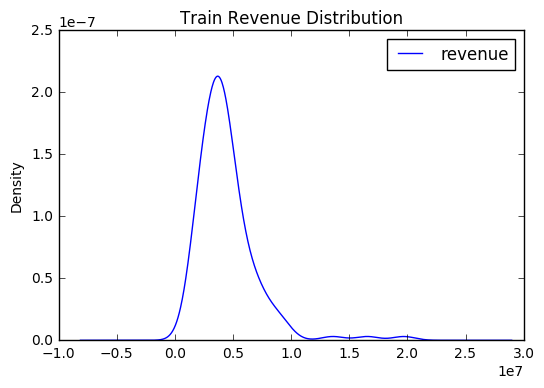

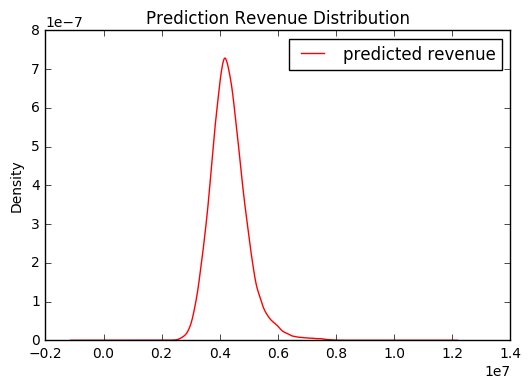

In [94]:
# Another quick comparision. Note the x-axis scale change: the predictions are 
# more conservative and tend to be closer to the mean than the real revenues. 
# This is pretty standard behavior when using RMSE - there are big penalties for 
# being very wrong, so the model will tend towards more moderate predictions.
import matplotlib.pyplot as plt
%matplotlib inline
train[['revenue']].plot(kind='kde', title="Train Revenue Distribution")
submission.columns = ["predicted revenue"]
submission.plot(kind='kde', title="Prediction Revenue Distribution", color='r')
plt.show()